In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import spacy
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.manifold import TSNE



# Exploratory Data Analysis (EDA)

In [3]:
file_path = 'data/DisneylandReviews.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')
print(df.head())

   Review_ID  Rating Year_Month     Reviewer_Location  \
0  670772142       4     2019-4             Australia   
1  670682799       4     2019-5           Philippines   
2  670623270       4     2019-4  United Arab Emirates   
3  670607911       4     2019-4             Australia   
4  670607296       4     2019-4        United Kingdom   

                                         Review_Text               Branch  
0  If you've ever been to Disneyland anywhere you...  Disneyland_HongKong  
1  Its been a while since d last time we visit HK...  Disneyland_HongKong  
2  Thanks God it wasn   t too hot or too humid wh...  Disneyland_HongKong  
3  HK Disneyland is a great compact park. Unfortu...  Disneyland_HongKong  
4  the location is not in the city, took around 1...  Disneyland_HongKong  


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB
None


In [5]:
print(df.describe())

          Review_ID        Rating
count  4.265600e+04  42656.000000
mean   3.188553e+08      4.217695
std    1.657092e+08      1.063371
min    1.398724e+06      1.000000
25%    1.743274e+08      4.000000
50%    2.907583e+08      5.000000
75%    4.489579e+08      5.000000
max    6.708014e+08      5.000000


In [6]:
print(df.isnull().sum())

Review_ID            0
Rating               0
Year_Month           0
Reviewer_Location    0
Review_Text          0
Branch               0
dtype: int64


In [13]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_percentage = (missing_values / len(df)) * 100
missing_info = pd.DataFrame({'Missing Values': missing_values, 'Missing Percentage': missing_percentage})

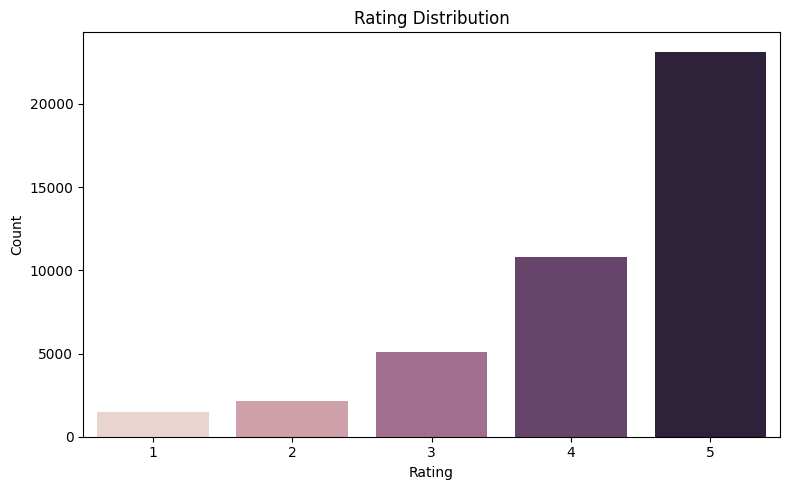

In [8]:
# Visualization 1: Rating Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Rating', hue='Rating', dodge=False, legend=False)
plt.title('Rating Distribution')
plt.ylabel('Count')
plt.xlabel('Rating')
plt.tight_layout()
plt.savefig('images/rating_distribution.png')
plt.show()

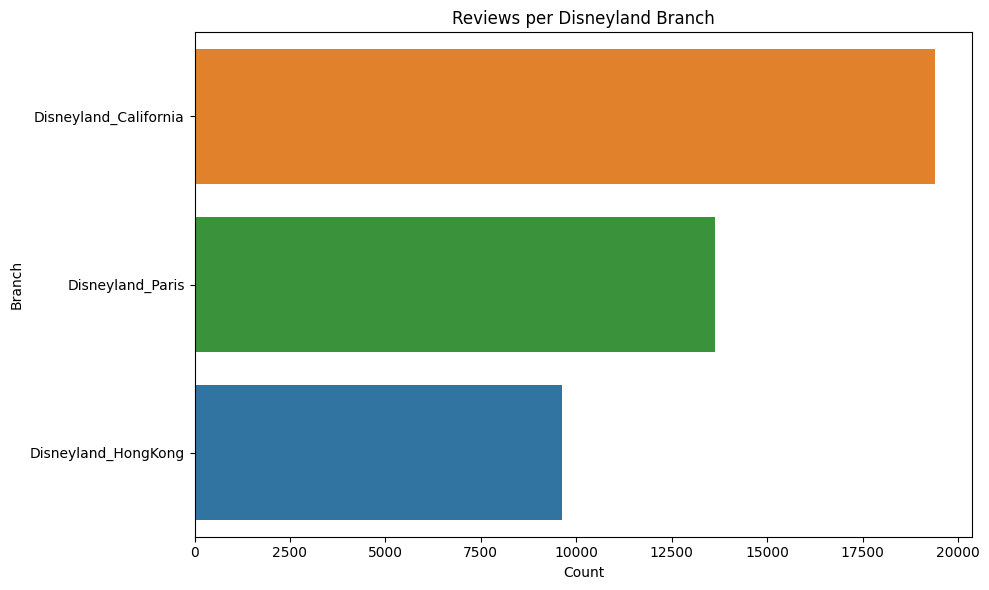

In [10]:
# Visualization 2: Reviews per Disneyland Branch
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='Branch', hue='Branch', dodge=False, order=df['Branch'].value_counts().index,
                legend=False)
plt.title('Reviews per Disneyland Branch')
plt.xlabel('Count')
plt.ylabel('Branch')
plt.tight_layout()
plt.savefig('images/branch_distribution.png')
plt.show()

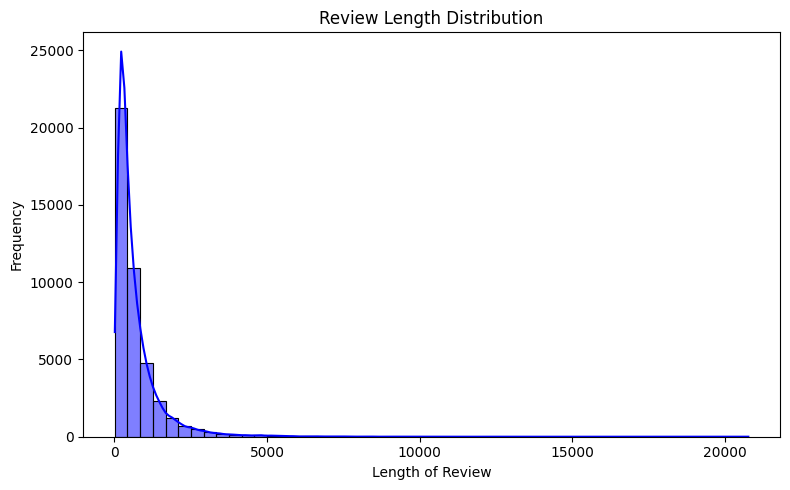

In [15]:
# Visualization 3: Review Length Distribution
df['Review_Length'] = df['Review_Text'].apply(len)
plt.figure(figsize=(8, 5))
sns.histplot(df['Review_Length'], bins=50, kde=True, color='blue')
plt.title('Review Length Distribution')
plt.xlabel('Length of Review')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('images/review_length.png')
plt.show()

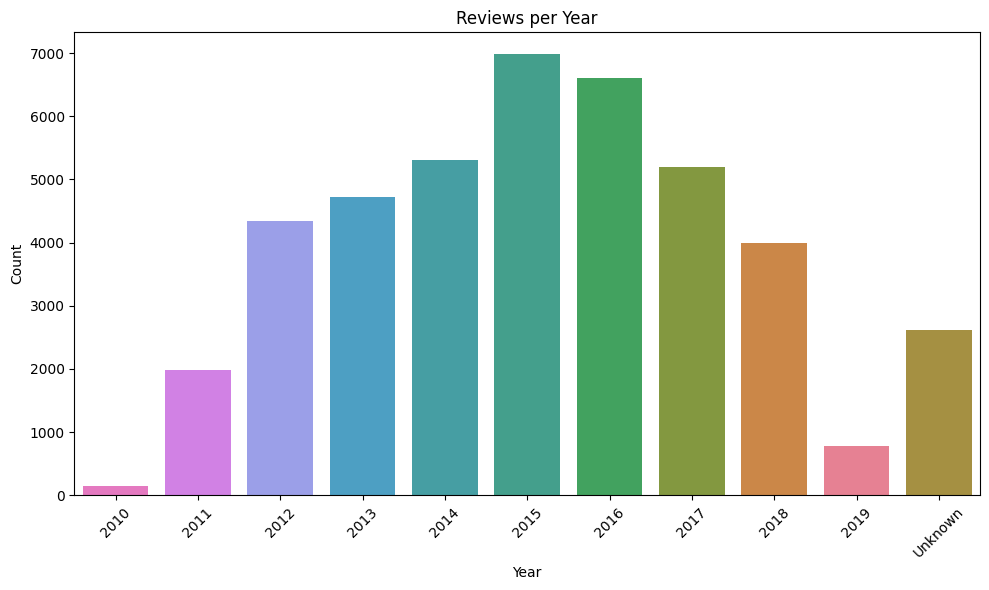

In [16]:
# Visualization 4: Reviews per Year
df['Year'] = df['Year_Month'].apply(lambda x: x.split('-')[0] if x != 'missing' else 'Unknown')
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Year', hue='Year', dodge=False, order=sorted(df['Year'].unique()), legend=False)
plt.title('Reviews per Year')
plt.ylabel('Count')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('images/year_distribution.png')
plt.show()

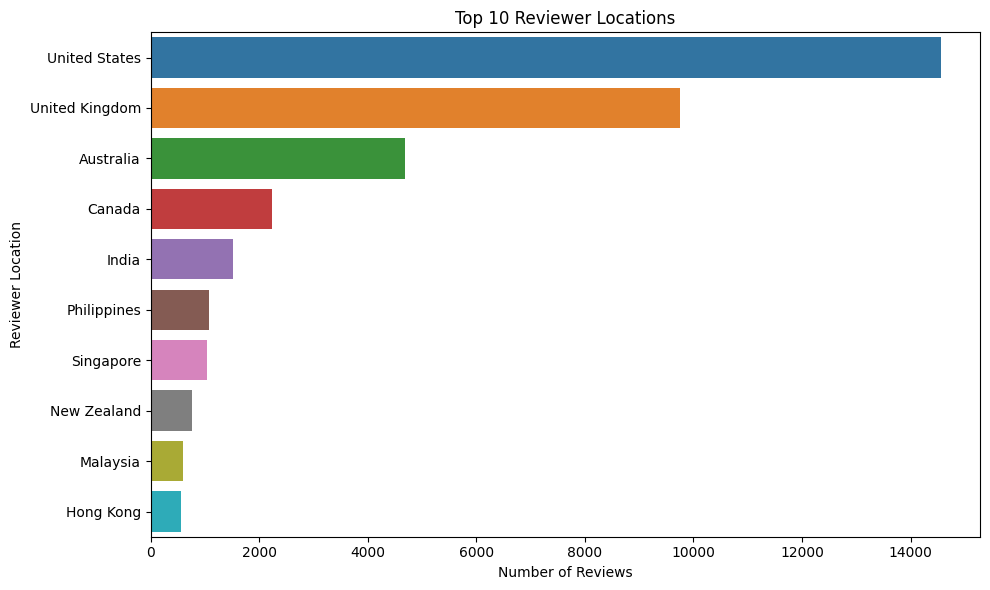

In [17]:
# Visualization 5: Reviews per Reviewer Location (Top 10)
top_locations = df['Reviewer_Location'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_locations, y=top_locations.index, hue=top_locations.index, dodge=False, legend=False)
plt.title('Top 10 Reviewer Locations')
plt.xlabel('Number of Reviews')
plt.ylabel('Reviewer Location')
plt.tight_layout()
plt.savefig('images/top_locations.png')
plt.show()

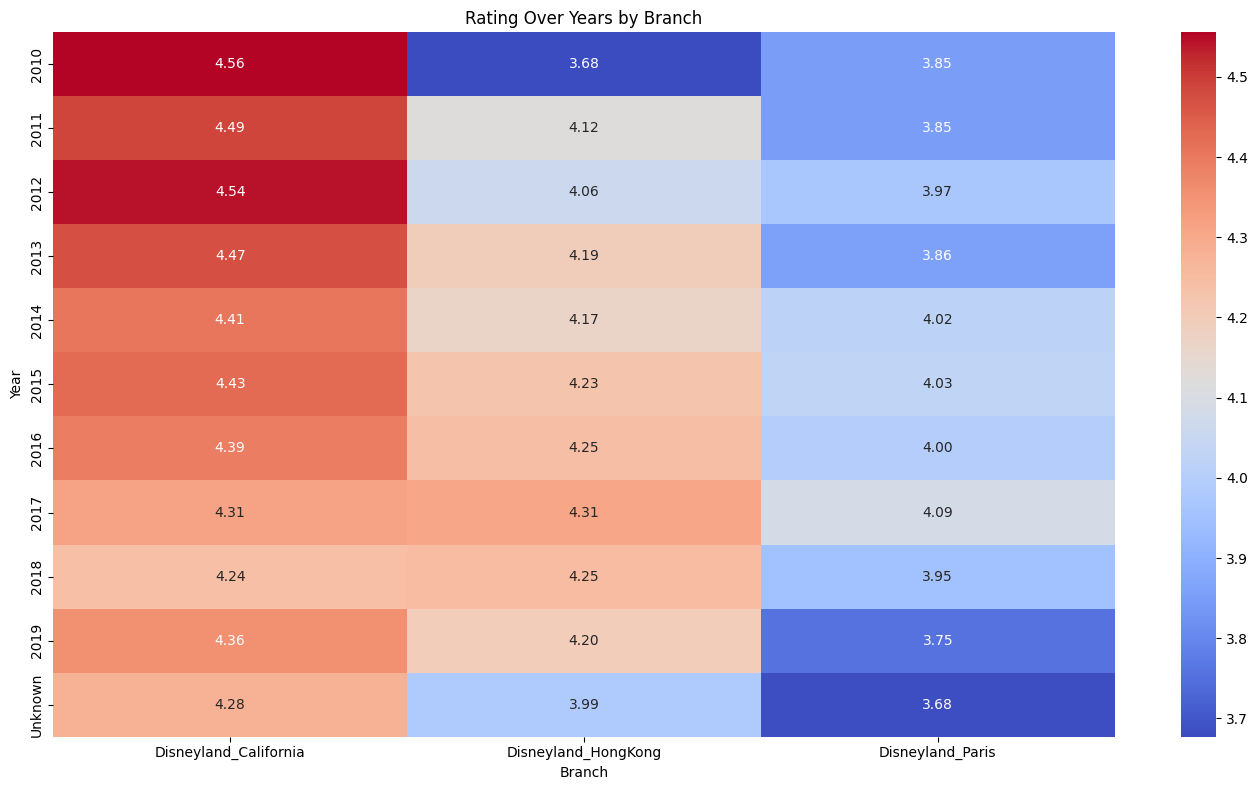

In [18]:
# Visualization 6: Rating Over Years by Branch
rating_per_year_branch = df.groupby(['Year', 'Branch'])['Rating'].mean().unstack()
plt.figure(figsize=(14, 8))
sns.heatmap(rating_per_year_branch, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Rating Over Years by Branch')
plt.tight_layout()
plt.savefig('images/rating_over_years_by_branch.png')
plt.show()

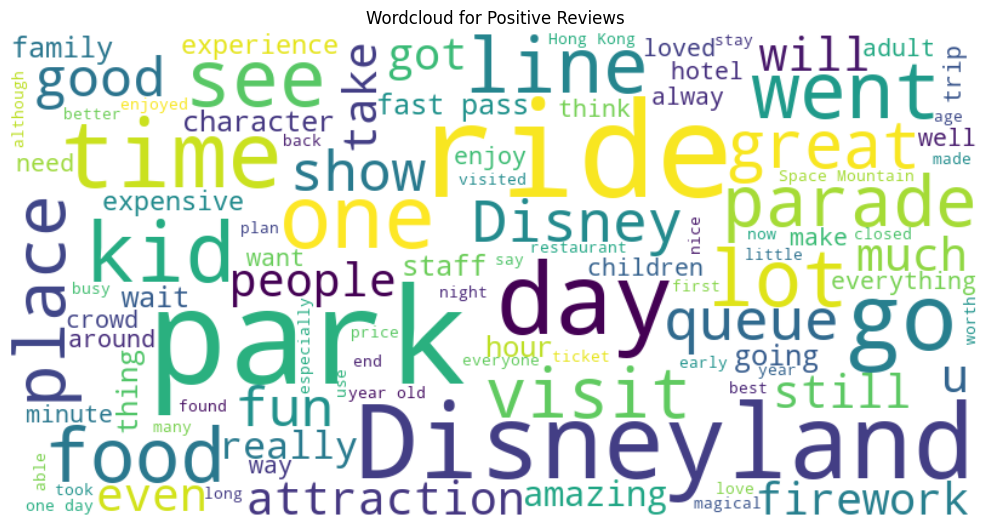

In [19]:
# Visualization 7: Wordcloud for positive reviews with 4 or 5 rating
positive_reviews = df[df['Rating'] >= 4]
positive_reviews_text = ' '.join(positive_reviews['Review_Text'])
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white',
                        max_words=100).generate(positive_reviews_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Wordcloud for Positive Reviews')
plt.tight_layout()
plt.savefig('images/wordcloud_positive_reviews.png')
plt.show()

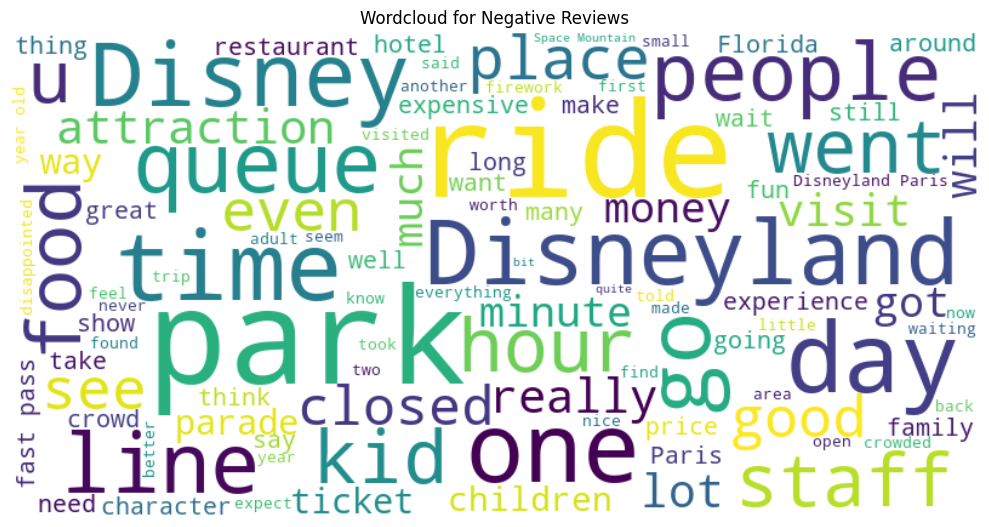

In [20]:
# Visualization 8: Wordcloud for negative reviews with 1, 2 or 3 rating
negative_reviews = df[df['Rating'] <= 3]
negative_reviews_text = ' '.join(negative_reviews['Review_Text'])
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white',
                        max_words=100).generate(negative_reviews_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Wordcloud for Negative Reviews')
plt.tight_layout()
plt.savefig('images/wordcloud_negative_reviews.png')
plt.show()

# Data preprocessing

In [22]:
# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Load English tokenizer, tagger, parser, NER, and word vectors
# Disabling unnecessary components for efficiency
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

[nltk_data] Downloading package punkt to
[nltk_data]     E:\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     E:\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Custom stopwords
custom_stopwords = {
    'disney', 'land', 'disneyland', 'rides', 'ride', 'good', 'really', 'very', 'quite',
    'pretty', 'especially', 'actually', 'probably', 'maybe', 'sure', 'time', 'day', 'year',
    'thing', 'world', 'point', 'bit', 'number', 'week', 'make', 'say', 'come', 'go', 'know',
    'take', 'see', 'get', 'want', 'think', 'look', 'tell', 'try', 'use', 'need', 'feel',
    'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them', 'my',
    'your', 'his', 'its', 'our', 'their', 'a', 'an', 'the', 'in', 'on', 'at', 'from', 'with',
    'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below',
    'over', 'under', 'to', 'of', 'for', 'by', 'and', 'but', 'or', 'so', 'yet', 'because',
    'as', 'until', 'than', '10', '20', '30', '45', '15', 'minute', 'second', 'hour', 'day', 'pm'
                                                                                            'park', 'go', 'one', 'kid'
}

# Update stop words list
stop_words = set(stopwords.words('english')).union(custom_stopwords)

In [24]:
low_rating_threshold = 3
clean_df = df[df['Rating'] <= low_rating_threshold]

In [25]:
# Handling negations by creating bi-grams with negation word and subsequent word.
def handle_negations(text):
    # Define the negation pattern
    negation_pattern = re.compile(
        r"\b(not|no|never|none|cannot|can't|couldn't|shouldn't|won't|wouldn't|don't|doesn't|didn't|isn't|aren't|ain't"
        r")\s([a-z]+)\b",
        re.IGNORECASE
    )
    negated_form = r'\1_\2'  # E.g., "not_good"
    return negation_pattern.sub(negated_form, text)


# Function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Normalize text to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove punctuation
    text = handle_negations(text)  # Handle negations
    tokens = word_tokenize(text)  # Tokenize text
    tokens = [token for token in tokens if token not in stop_words]  # Remove stop words
    lemmatized = nlp(' '.join(tokens))  # Lemmatization
    lemmatized = [token.lemma_ for token in lemmatized]
    return ' '.join(lemmatized)


# Apply preprocessing to the Review_Text column of the DataFrame
clean_df['Clean_Text'] = clean_df['Review_Text'].apply(preprocess_text)

C:\Users\moham\AppData\Local\Temp\ipykernel_12068\156666669.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Clean_Text'] = clean_df['Review_Text'].apply(preprocess_text)


In [26]:
# Display the first few rows of the processed data
print(clean_df[['Review_Text', 'Clean_Text']].head())

# Export to a new CSV file
clean_df.to_csv('data/cleaned_reviews.csv', index=False)

                                          Review_Text  \
5   Have been to Disney World, Disneyland Anaheim ...   
7   Think of it as an intro to Disney magic for th...   
8   Feel so let down with this place,the Disneylan...   
15  We brought tickets before we left and got 2 da...   
17  Around   60 per person and if you want to eat ...   

                                           Clean_Text  
5   anaheim tokyo hong kong small call way attract...  
7   intro magic little one almost attraction compl...  
8   let placethe train fantastic past stationbad s...  
15  bring ticket leave get 2 day less price 1 visi...  
17  around 60 per person eat drink cost small fort...  


# Bag of Words (BoW) model + LDA, LSA, NMF

In [28]:
# Initialize CountVectorizer and fit and transform
count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(2, 3), min_df=5, max_df=0.5)
count_vectors = count_vectorizer.fit_transform(clean_df['Clean_Text'])

In [29]:
# Sum up the counts of each vocabulary word
sum_words = count_vectors.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()]
sorted_words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

In [30]:
# Display the top N most frequent words
top_n = 30
print("\nTop {} most frequent words/ngrams:".format(top_n))
print("-" * 40)
for word, freq in sorted_words_freq[:top_n]:
    print("{:<20} : {}".format(word, freq))
print("-" * 40)


Top 30 most frequent words/ngrams:
----------------------------------------
fast pass            : 1677
theme park           : 779
space mountain       : 756
cast member          : 695
hong kong            : 662
wait line            : 528
thunder mountain     : 482
long queue           : 439
long line            : 430
indiana jones        : 425
visit park           : 422
year ago             : 383
main street          : 366
young child          : 362
california adventure : 359
wait time            : 339
customer service     : 323
happy place          : 314
attraction close     : 308
feel like            : 294
stand line           : 294
long wait            : 292
roller coaster       : 291
place earth          : 291
pirate caribbean     : 288
line long            : 280
visit paris          : 280
food drink           : 274
peter pan            : 271
queue long           : 270
----------------------------------------


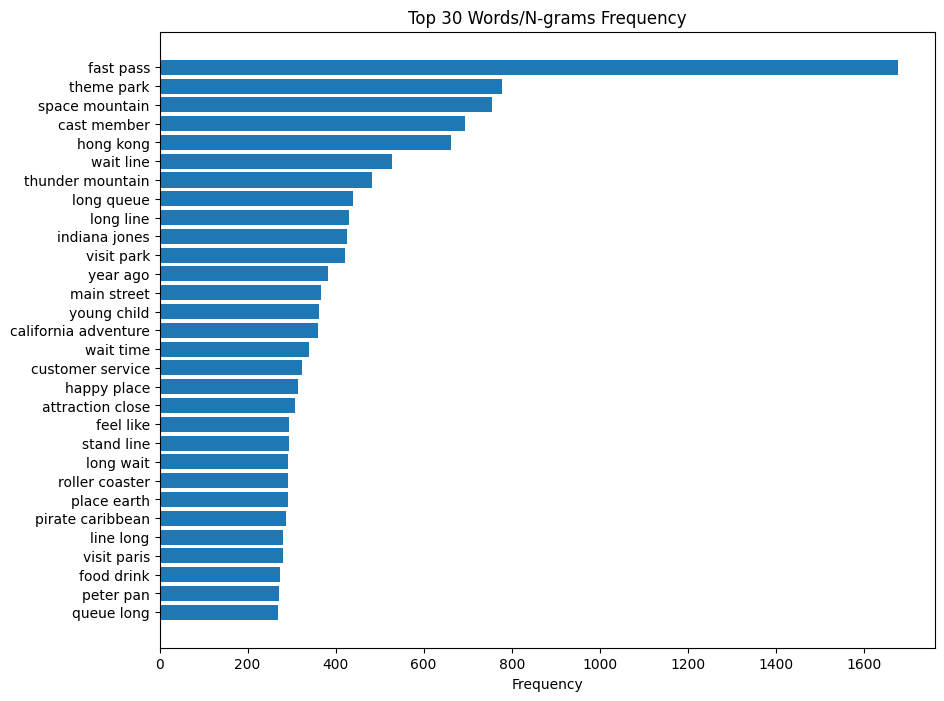

In [33]:
# Plotting the top N words/ngrams
top_n = 30
words, freqs = zip(*sorted_words_freq[:top_n])
plt.figure(figsize=(10, 8))
plt.barh(range(len(words)), freqs, align='center')
plt.yticks(range(len(words)), words)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency on top
plt.xlabel('Frequency')
plt.title('Top {} Words/N-grams Frequency'.format(top_n))
plt.show()

In [34]:
# Number of topics and top words to display
n_topics = 4
no_top_words = 10

# Initialize and fit LDA, LSA, and NMF models
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42).fit(count_vectors)
lsa = TruncatedSVD(n_components=n_topics).fit(count_vectors)
nmf = NMF(n_components=n_topics, random_state=42).fit(count_vectors)

In [35]:
# Function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic {}:".format(topic_idx + 1))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display topics for each model
print("\nLDA Model Topics:")
display_topics(lda, count_vectorizer.get_feature_names_out(), no_top_words)
print("\nLSA Model Topics:")
display_topics(lsa, count_vectorizer.get_feature_names_out(), no_top_words)
print("\nNMF Model Topics:")
display_topics(nmf, count_vectorizer.get_feature_names_out(), no_top_words)


LDA Model Topics:

Topic 1:
hong kong, space mountain, thunder mountain, indiana jones, attraction close, big thunder, pirate caribbean, big thunder mountain, roller coaster, visit park

Topic 2:
theme park, customer service, fast pass, feel like, cast member, space mountain, small child, food drink, visit park, look forward

Topic 3:
young child, theme park, long queue, stay hotel, fast pass, queue long, fast food, visit paris, young kid, space mountain

Topic 4:
fast pass, cast member, wait line, long line, california adventure, wait time, happy place, stand line, place earth, theme park

LSA Model Topics:

Topic 1:
fast pass, cast member, space mountain, wait line, theme park, thunder mountain, indiana jones, california adventure, wait time, main street

Topic 2:
cast member, space mountain, theme park, hong kong, main street, thunder mountain, customer service, indiana jones, big thunder, wait line

Topic 3:
cast member, fast pass, ask cast, ask cast member, customer service, city

Word Cloud for LDA Topic 1:


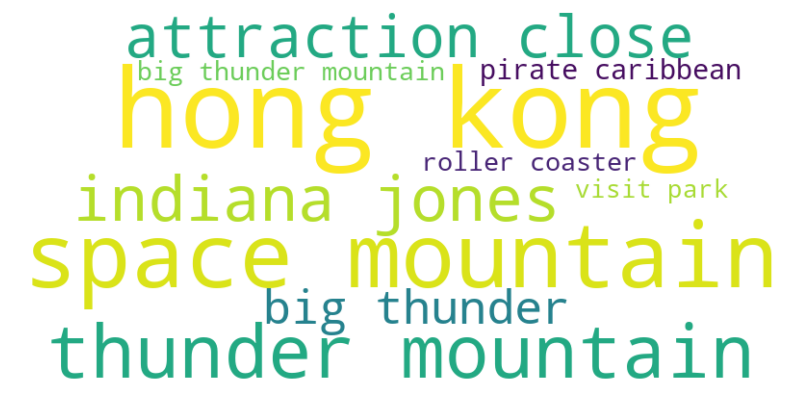

Word Cloud for LDA Topic 2:


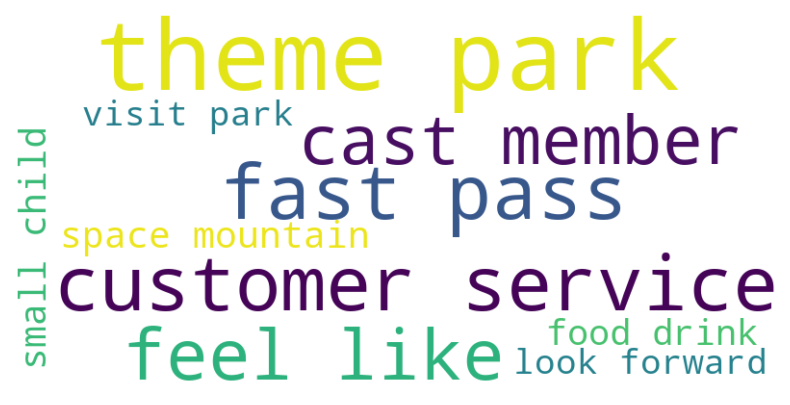

Word Cloud for LDA Topic 3:


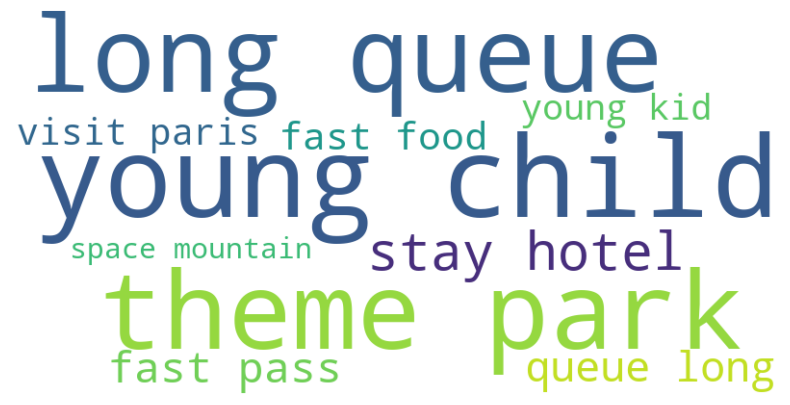

Word Cloud for LDA Topic 4:


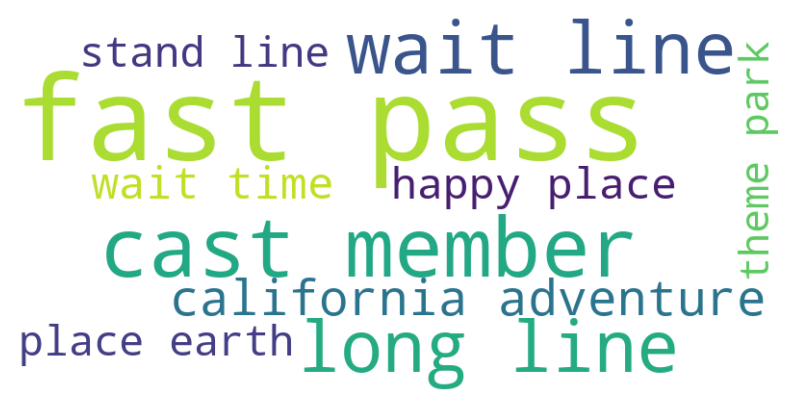

In [36]:
# Function to generate a word cloud
def generate_word_cloud(topic, feature_names, no_top_words):
    word_freqs = {feature_names[i]: topic[i] for i in topic.argsort()[:-no_top_words - 1:-1]}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freqs)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Generate word clouds for LDA topics
for topic_idx, topic in enumerate(lda.components_):
    print("Word Cloud for LDA Topic {}:".format(topic_idx + 1))
    generate_word_cloud(topic, count_vectorizer.get_feature_names_out(), no_top_words)


Performing t-SNE Visualization...


d:\git\NLP-Disneyland-Reviews\venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\git\NLP-Disneyland-Reviews\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


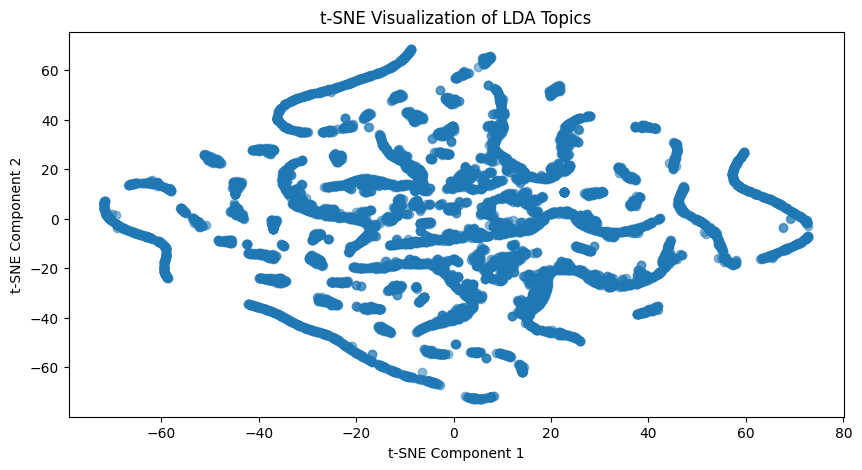

In [38]:
# t-SNE Visualization for LDA
def tsne_visualization(model, data):
    print("\nPerforming t-SNE Visualization...")
    topic_weights = model.transform(data)
    tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
    tsne_lda = tsne_model.fit_transform(topic_weights)

    # Plot the t-SNE visualization
    plt.figure(figsize=(10, 5))
    plt.scatter(tsne_lda[:, 0], tsne_lda[:, 1], alpha=0.5)
    plt.title('t-SNE Visualization of LDA Topics')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

tsne_visualization(lda, count_vectors)

# TF-IDF model + LDA, LSA, NMF

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.manifold import TSNE
from wordcloud import WordCloud

# Load the preprocessed data
file_path = 'data/cleaned_reviews.csv'
clean_df = pd.read_csv(file_path)

# Initialize TfidfVectorizer and fit and transform
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), min_df=5, max_df=0.5)
tfidf_vectors = tfidf_vectorizer.fit_transform(clean_df['Clean_Text'])

# Function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic {}:".format(topic_idx + 1))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Function to plot word frequencies
def plot_word_frequencies(words, freqs, title):
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(words)), freqs, align='center')
    plt.yticks(range(len(words)), words)
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency on top
    plt.xlabel('Frequency')
    plt.title(title)
    plt.savefig('images/word_frequencies.png')
    plt.show()

# Function to generate a word cloud
def generate_word_cloud(topic, feature_names, no_top_words):
    word_freqs = {feature_names[i]: topic[i] for i in topic.argsort()[:-no_top_words - 1:-1]}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freqs)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig('images/tfidf_word_cloud.png')
    plt.show()

# Sum up the TF-IDF scores of each vocabulary word
sum_tfidf = tfidf_vectors.sum(axis=0)
words_tfidf = [(word, sum_tfidf[0, idx]) for word, idx in tfidf_vectorizer.vocabulary_.items()]
sorted_words_tfidf = sorted(words_tfidf, key=lambda x: x[1], reverse=True)

# Display the top N words with the highest TF-IDF score
top_n = 30
print("\nTop {} words with the highest TF-IDF scores:".format(top_n))
print("-" * 40)
for word, score in sorted_words_tfidf[:top_n]:
    print("{:<20} : {}".format(word, score))
print("-" * 40)

# Plotting the top N words with the highest TF-IDF scores
top_words, top_scores = zip(*sorted_words_tfidf[:top_n])
plot_word_frequencies(top_words, top_scores, 'Top {} Words with Highest TF-IDF Scores'.format(top_n))

# Number of topics and top words to display
n_topics = 4
no_top_words = 10

# Initialize and fit LDA, LSA, and NMF models
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42).fit(tfidf_vectors)
lsa = TruncatedSVD(n_components=n_topics).fit(tfidf_vectors)
nmf = NMF(n_components=n_topics, random_state=42).fit(tfidf_vectors)

# Display topics for each model
print("\nLDA Model Topics:")
display_topics(lda, tfidf_vectorizer.get_feature_names_out(), no_top_words)
print("\nLSA Model Topics:")
display_topics(lsa, tfidf_vectorizer.get_feature_names_out(), no_top_words)
print("\nNMF Model Topics:")
display_topics(nmf, tfidf_vectorizer.get_feature_names_out(), no_top_words)

# Generate word clouds for LDA topics
for topic_idx, topic in enumerate(lda.components_):
    print("Word Cloud for LDA Topic {}:".format(topic_idx + 1))
    generate_word_cloud(topic, tfidf_vectorizer.get_feature_names_out(), no_top_words)

# t-SNE Visualization for LDA
def tsne_visualization(model, data):
    print("\nPerforming t-SNE Visualization...")
    topic_weights = model.transform(data)
    tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
    tsne_lda = tsne_model.fit_transform(topic_weights)
    return tsne_lda

# Plot t-SNE
def plot_tsne(tsne_results, title):
    plt.figure(figsize=(12, 8))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.7)
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.title(title)
    plt.savefig('images/tfidf_tsne_lda.png')
    plt.show()

tsne_lda = tsne_visualization(lda, tfidf_vectors)
plot_tsne(tsne_lda, 't-SNE Visualization of LDA Topics')


if __name__ == "__main__":
    # This script can be run as a standalone program, with the above functions defined.
    pass

In [ ]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# load the preprocessed reviews
df = pd.read_csv('data/DisneylandReviews.csv', encoding='ISO-8859-1')

# calculate sentiment and put it in a new column
df['sentiment'] = df['Review_Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# convert sentiment to positive or negative and put it in a new column
df['sentiment_cat'] = df['sentiment'].apply(lambda x: 'positive' if x > 0 else 'negative')

# Save the sentiment analysis results
df.to_csv('data/sentiment_analysis.csv', index=False)

# plot the sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], kde=True, color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('images/sentiment_distribution.png')
plt.show()

# plot the sentiment distribution by category
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment_cat', hue='sentiment_cat', dodge=False, palette='pastel')
plt.title('Sentiment Distribution by Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('images/sentiment_category_distribution.png')
plt.show()

# Sentiment Analysis using Vader
# Create a SentimentIntensityAnalyzer object
analyzer = SentimentIntensityAnalyzer()

# Define a function to get the sentiment score
def get_sentiment_score(text):
    return analyzer.polarity_scores(text)['compound']

# Calculate the sentiment score and put it in a new column
df['sentiment_vader'] = df['Review_Text'].apply(get_sentiment_score)

# Convert sentiment to positive or negative and put it in a new column
df['sentiment_cat_vader'] = df['sentiment_vader'].apply(lambda x: 'positive' if x > 0 else 'negative')

# Compare the sentiment scores from TextBlob and vaderSentiment
print("The average sentiment score from TextBlob is:")
print(df['sentiment'].mean())
print("The average sentiment score from vaderSentiment is:")
print(df['sentiment_vader'].mean())

# Compare the sentiment categories from TextBlob and vaderSentiment
print("The sentiment category distribution from TextBlob is:")
print(df['sentiment_cat'].value_counts())
print("The sentiment category distribution from vaderSentiment is:")
print(df['sentiment_cat_vader'].value_counts())

# Compare the standard deviation of the sentiment scores from TextBlob and vaderSentiment
print("The standard deviation of the sentiment scores from TextBlob is:")
print(df['sentiment'].std())
print("The standard deviation of the sentiment scores from vaderSentiment is:")
print(df['sentiment_vader'].std())

# plot the sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment_vader'], kde=True, color='skyblue')
plt.title('Sentiment Distribution (vaderSentiment)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('images/sentiment_distribution_vader.png')
plt.show()

# plot the sentiment distribution by category
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment_cat_vader', hue='sentiment_cat_vader', dodge=False, palette='pastel')
plt.title('Sentiment Distribution by Category (vaderSentiment)')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('images/sentiment_category_distribution_vader.png')
plt.show()


# Save the sentiment analysis results
df.to_csv('data/sentiment_analysis.csv', index=False)

In [ ]:
import pandas as pd
from gensim.models import Word2Vec
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pyLDAvis.gensim


# Load the preprocessed reviews
preprocessed_reviews = []
df = pd.read_csv('data/cleaned_reviews.csv')
for review in df['Clean_Text']:
    preprocessed_reviews.append(word_tokenize(review))

# Train Word2Vec model
model = Word2Vec(preprocessed_reviews, window=5, min_count=1, workers=4)

# Represent reviews as vectors
review_vectors = [model.wv[token] for review in preprocessed_reviews for token in review]

# Apply LDA for topic modeling
dictionary = Dictionary(preprocessed_reviews)
corpus = [dictionary.doc2bow(review) for review in preprocessed_reviews]
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary)

# Print the topics
for topic in lda_model.print_topics():
    print(f"Topic {topic[0]}: {topic[1]}")
    print("\n")

# Save the Word2Vec model
model.wv.save('word2vec.model')

# Load the model
word2vec_model = KeyedVectors.load('word2vec.model')

# Use the Word2Vec model to find similar words
similar_words = word2vec_model.similar_by_word('line')
print(f"The words similar to 'line' are: {similar_words}")
print("\n")

# Use the Word2Vec model to find the similarity between two words
similarity = word2vec_model.similarity('queue', 'long')
print(f"The similarity between 'queue' and 'long' is {similarity}")

# Visualizing using pyLDAvis
import pyLDAvis
import IPython

# Visualize the topics
if IPython.get_ipython() is not None:
    pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(vis, 'lda_topics.html')

# Visualize the Word2Vec model using t-SNE
# Get the word vectors
word_vectors = word2vec_model.vectors

# Reduce the dimensionality of the word vectors using t-SNE
tsne = TSNE(n_components=2, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plot the word vectors in 2D
plt.figure(figsize=(10, 10))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], marker='o')
plt.title('t-SNE visualization of Word2Vec model')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.tight_layout()
plt.savefig('images/word2vec_tsne.png')
plt.show()

